# Modelling of !Kung people heights

In [63]:
import sys
sys.path.append('../../Utilities')

import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats

import pandas as pd


In [64]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [65]:
from DA_tools import ribbon_plot, light, light_highlight, mid, mid_highlight, dark, dark_highlight


### Loading data

In [66]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"


In [67]:
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults for now
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


## Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

### Prior predictive checks

In [68]:
with open('height_1_ppc.stan', 'r') as file:
    print(file.read())


generated quantities {
  real mu = normal_rng(178,20);
  real sigma = exponential_rng(0.067);
  real height = normal_rng(mu,sigma);
}



In [69]:
model_ppc=stan_utility.compile_model('height_1_ppc.stan')

Using cached StanModel


In [70]:
R = 1000
sim=model_ppc.sampling(data=dict(), 
                       iter=R, warmup=0, 
                       chains=1, 
                       refresh=R,
                       algorithm='Fixed_param',
                       seed=29042020)

In [71]:
params_sim=sim.extract()
mu_sim=params_sim['mu']
sigma_sim=params_sim['sigma']
height_sim=params_sim['height']

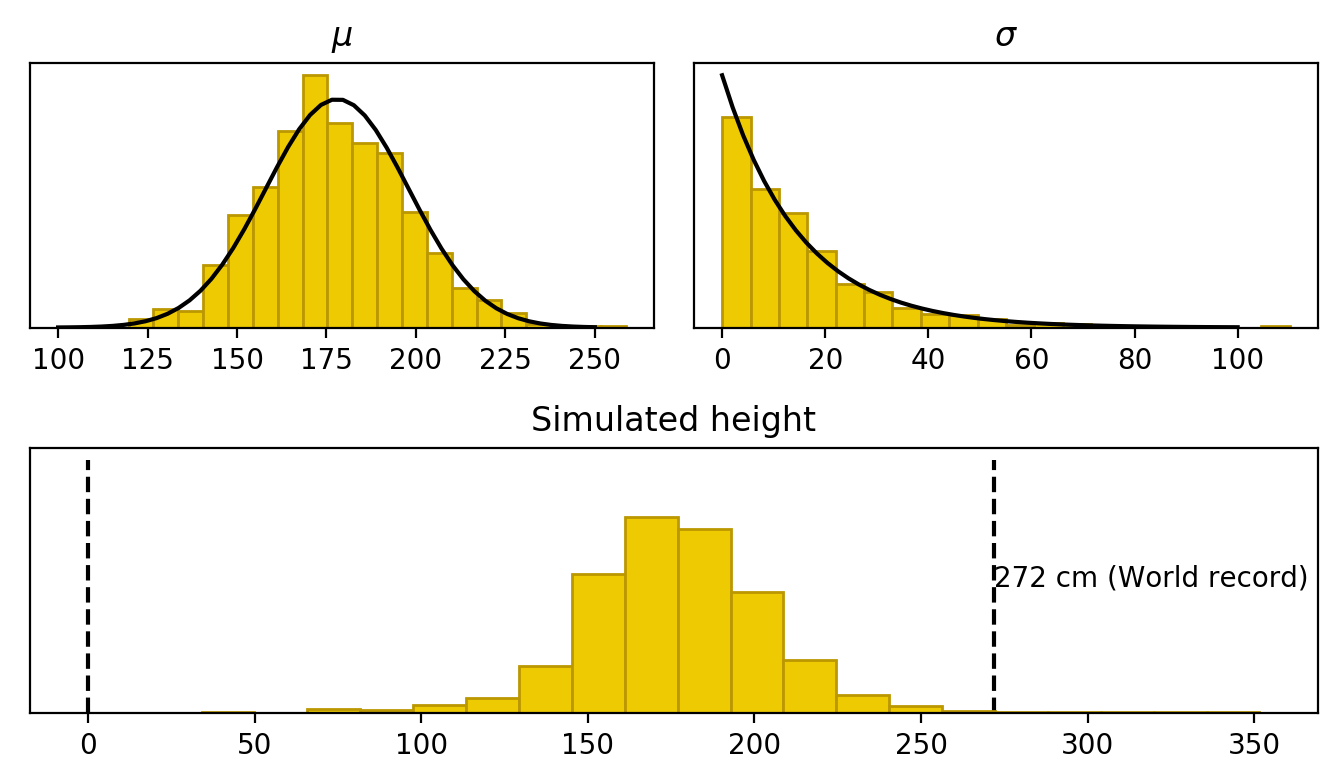

In [72]:
fig = plt.figure(figsize=(7, 4))

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[1, :])
ax1.hist(height_sim,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.vlines([0,272],ymin=0,ymax=2e-2,linestyle='--',color='black',zorder=1)
ax1.set_yticks([])
ax1.set_title('Simulated height')

ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax2.set_yticks([])
ax2.hist(mu_sim,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(100,250)
y=stats.norm.pdf(x,loc=178,scale=20)
ax2.plot(x,y,'black')
#ax2.set_xticks([-4,0,4])
ax2.set_title('$\mu$')
ax3.set_yticks([])
ax2.set_yticks([])
ax3.hist(sigma_sim,bins=20,color=dark,edgecolor=dark_highlight,density=True)
#ax3.set_xticks([-8,0,8])
x=np.linspace(0,100)
y=stats.expon.pdf(x,scale=15)
ax3.plot(x,y,color='black')
ax3.set_title('$\sigma$')
ax1.annotate(s='272 cm (World record)',xy=(272,0.01))

fig.tight_layout()
plt.show()

### Posterior and inference

In [73]:
with open('height_1_fit.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real heights[N];
}

parameters {
  real mu;
  real<lower=0> sigma;
}

model {
  mu ~ normal(178,20);
  sigma ~ exponential(0.067);
  heights ~ normal(mu,sigma);
}

generated quantities {
  real height = normal_rng(mu,sigma);
}



In [74]:
model_1_fit=stan_utility.compile_model('height_1_fit.stan')

Using cached StanModel


In [75]:
fit=model_1_fit.sampling(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

In [76]:
az.summary(fit,var_names=['mu','sigma'],round_to=2,kind='stats')

,mean,sd,hpd_3%,hpd_97%
mu,154.61,0.41,153.83,155.38
sigma,7.77,0.29,7.25,8.37


In [77]:
params_fit=fit.extract()
mu_fit=params_fit['mu']
sigma_fit=params_fit['sigma']
height_pred=params_fit['height']

/Users/jerzybaranowski/opt/anaconda3/envs/lectures/lib/python3.7/site-packages/arviz/plots/plot_utils.py:893: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(cov ** 0.5)


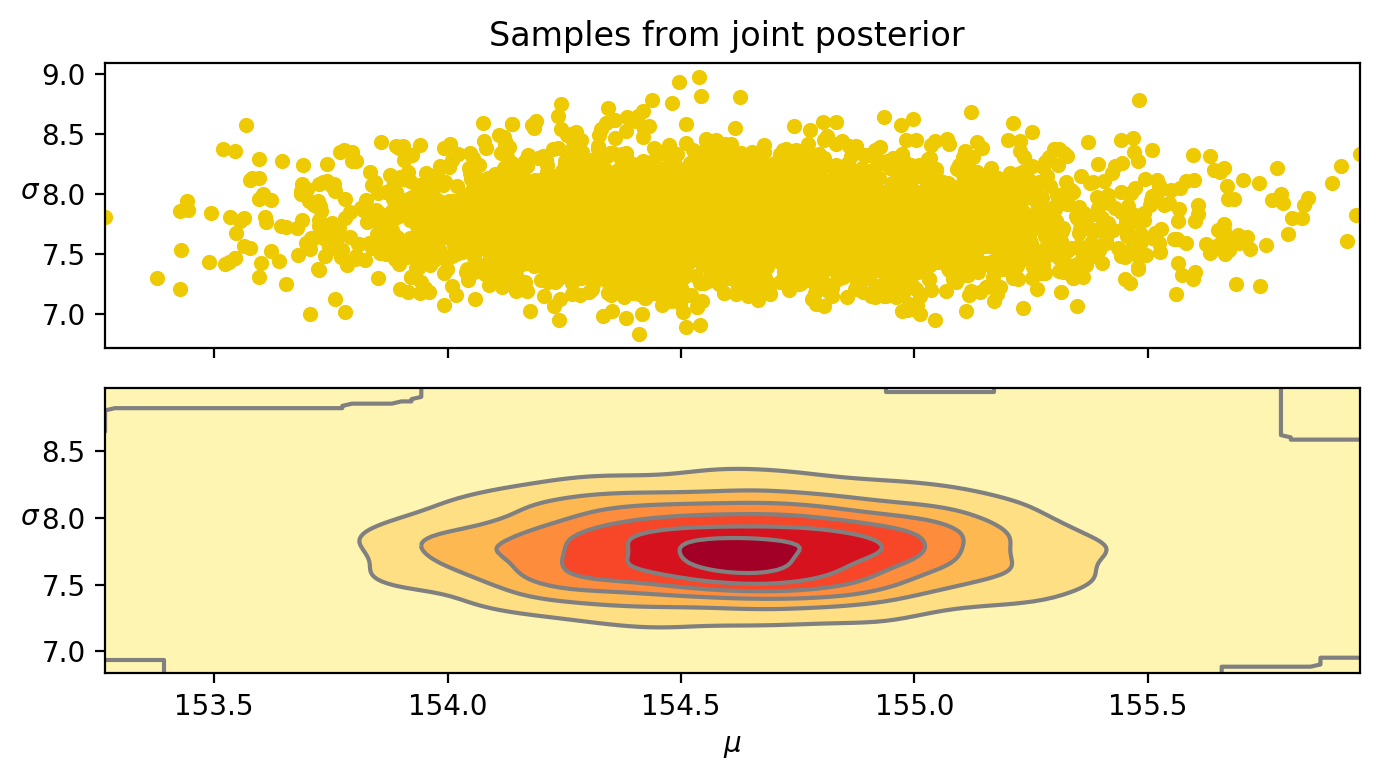

In [78]:
fig, axes = plt.subplots(2, 1, figsize=(7, 4),sharex=True)
ax1=axes[0]
ax1.scatter(mu_fit, sigma_fit, 20, color=dark)
ax1.set_ylabel(r'$\sigma$',rotation=0)
ax1.set_title('Samples from joint posterior ')
ax2=axes[1]
az.plot_kde(mu_fit,sigma_fit,ax=ax2,contourf_kwargs={'cmap':'YlOrRd'})
fig.tight_layout()
ax2.set_xlabel(r'$\mu$')
ax2.set_ylabel(r'$\sigma$',rotation=0)
fig.tight_layout()

plt.show()

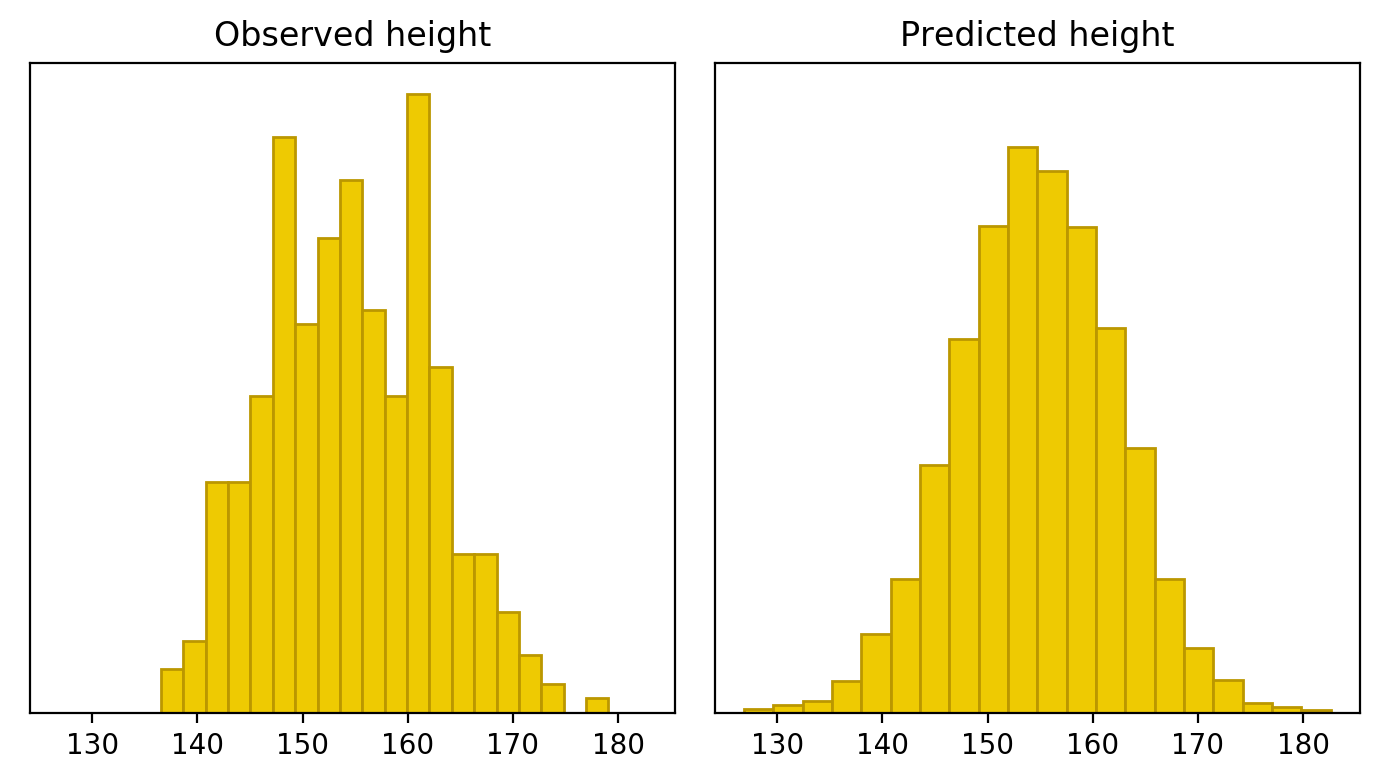

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4),sharex=True,sharey=True)
ax=axes[0]
ax.hist(d.height,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax.set_title('Observed height')
ax.set_yticks(());
ax2=axes[1]
ax2.hist(height_pred,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('Predicted height')
ax2.set_yticks(());
fig.tight_layout()

plt.show()

## Improving model - adding a predictor
Natural extension for our model is to add a predictor, in our case weight.


### Centering of variables

In [80]:
d['c_weight']=d.weight-d.weight.mean()
d.head()

,height,weight,age,male,c_weight
0,151.765,47.825606,63.0,1,2.835121
1,139.700,36.485807,63.0,0,-8.504679
2,136.525,31.864838,65.0,0,-13.125648
3,156.845,53.041915,41.0,1,8.051429
4,145.415,41.276872,51.0,0,-3.713614


### Prior predictive checks

In [81]:
with open('height_2a_ppc.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real weight[N];
}

generated quantities {
  real alpha = normal_rng(178,20);
  real beta = normal_rng(0,10);
  real sigma = exponential_rng(0.067);
  real height[N];
  for (i in 1:N) {
    height[N] = normal_rng(weight[N]*beta+alpha,sigma);
  }

}



In [82]:
model_ppc=stan_utility.compile_model('height_2a_ppc.stan')

Using cached StanModel


In [83]:
R = 1000
data_sim=dict(N=50,weight=np.linspace(d.c_weight.min(),d.c_weight.max()))
sim=model_ppc.sampling(data=data_sim, iter=R, warmup=0, chains=1, refresh=R,algorithm='Fixed_param',
                     seed=29042020)

In [84]:
params_sim=sim.extract()
alpha_sim=params_sim['alpha']
beta_sim=params_sim['beta']


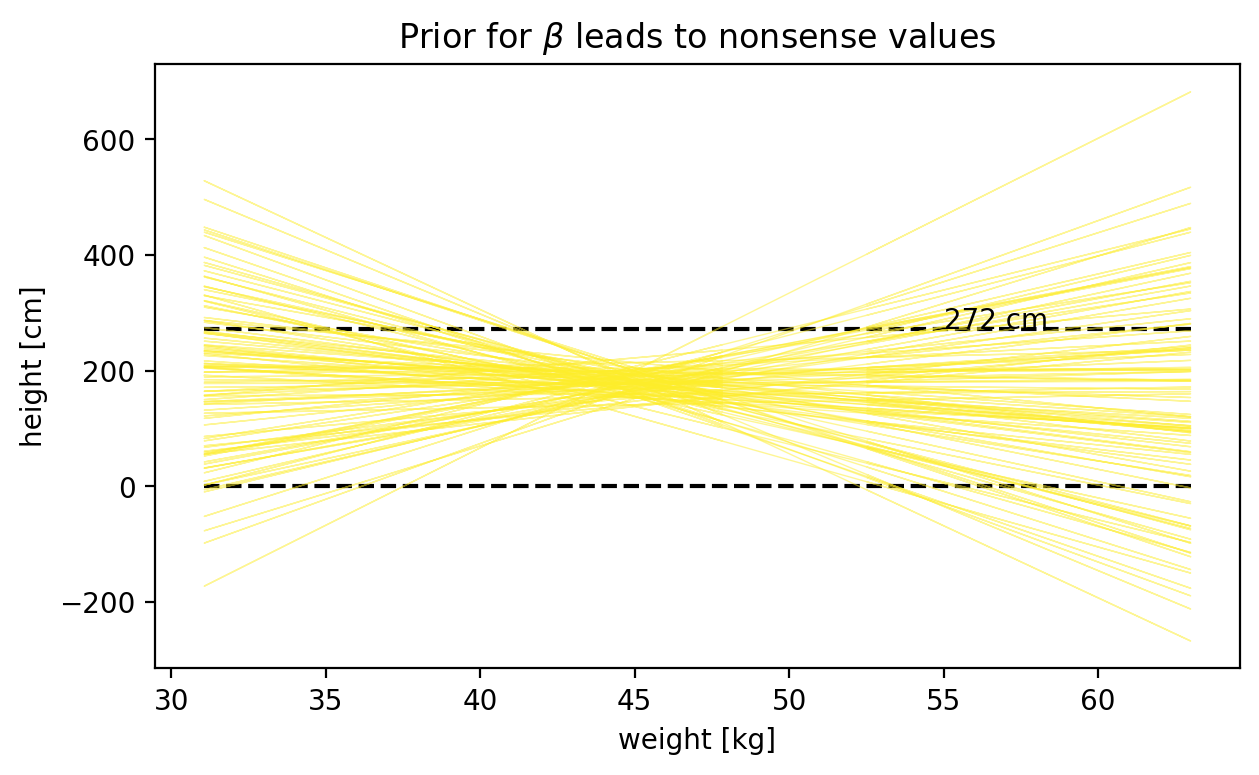

In [85]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines([0,272],xmin=d.weight.min(),xmax=d.weight.max(),linestyle='--',color='black')
for i in range(100):
    axes.plot(d.weight,alpha_sim[i]+beta_sim[i]*d.c_weight,color=mid,alpha=0.5,linewidth=0.5)
axes.set_xlabel('weight [kg]')
axes.set_ylabel('height [cm]')
axes.set_title(r'Prior for $\beta$ leads to nonsense values')
axes.annotate(s='272 cm', xy=(55,272))
plt.show()

### Prior modification

In [86]:
with open('height_2b_ppc.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real weight[N];
}

generated quantities {
  real alpha = normal_rng(178,20);
  real beta = lognormal_rng(0,1);
  real sigma = exponential_rng(0.067);
  real height[N];
  for (i in 1:N) {
    height[i] = normal_rng(weight[i]*beta+alpha,sigma);
  }

}



In [87]:
model_ppc=stan_utility.compile_model('height_2b_ppc.stan')

Using cached StanModel


In [88]:
R = 1000
data_sim=dict(N=50,weight=np.linspace(d.c_weight.min(),d.c_weight.max()))
sim=model_ppc.sampling(data=data_sim, iter=R, warmup=0, chains=1, refresh=R,algorithm='Fixed_param',
                     seed=29042020)

In [89]:
params_sim=sim.extract()
alpha_sim=params_sim['alpha']
beta_sim=params_sim['beta']


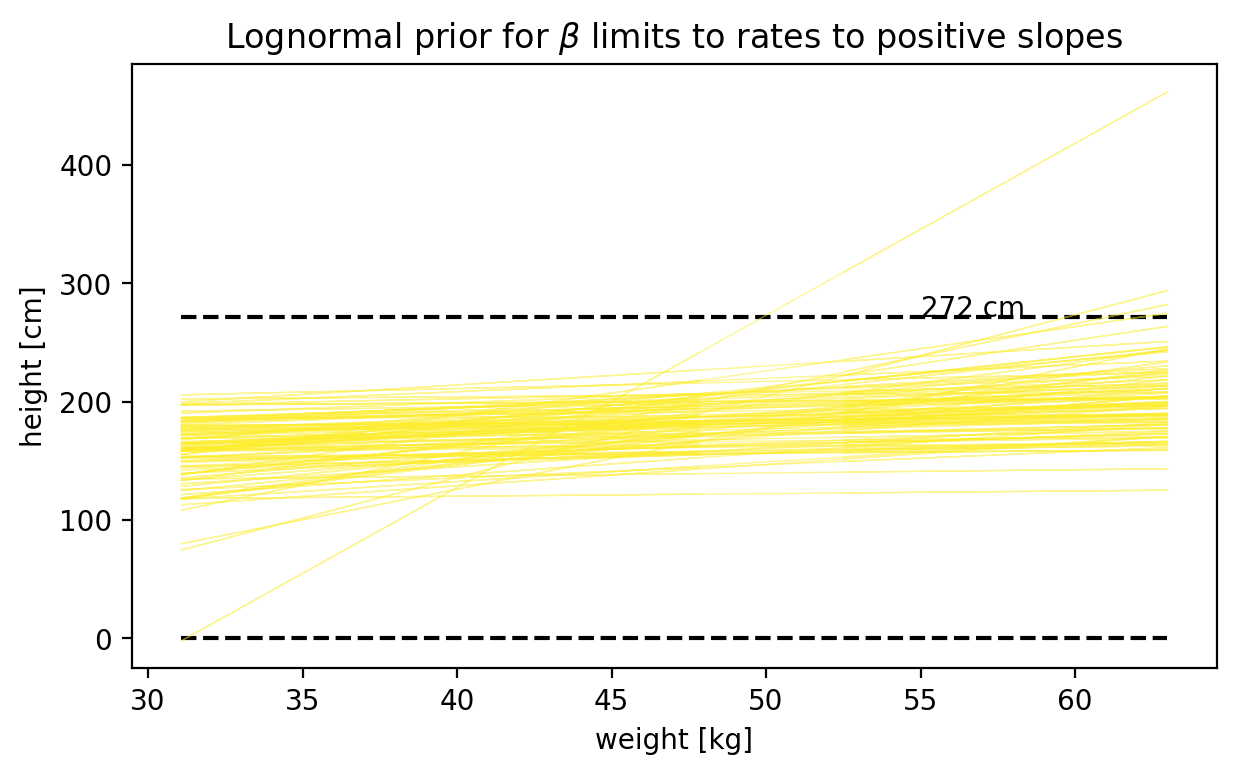

In [90]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines([0,272],xmin=d.weight.min(),xmax=d.weight.max(),linestyle='--',color='black')
for i in range(100):
    axes.plot(d.weight,alpha_sim[i]+beta_sim[i]*d.c_weight,color=mid,alpha=0.5,linewidth=0.5)
axes.set_xlabel('weight [kg]')
axes.set_ylabel('height [cm]')
axes.annotate(s='272 cm', xy=(55,272))
axes.set_title(r'Lognormal prior for $\beta$ limits to rates to positive slopes')
plt.show()

In [91]:
height_sim=params_sim['height']

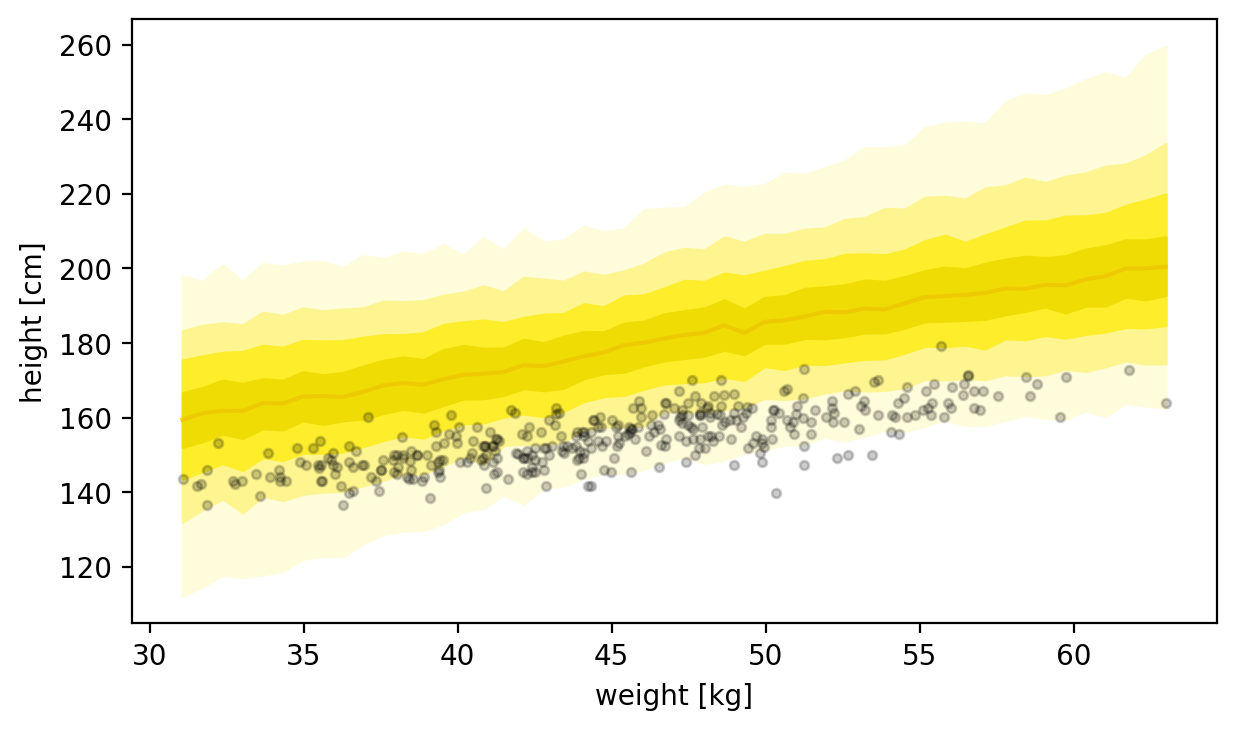

In [92]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes=ribbon_plot(data_sim['weight']+d.weight.mean(),height_sim,axes)
axes.scatter(d.weight,d.height,color='black',alpha=0.2,s=10)
axes.set_xlabel('weight [kg]')
axes.set_ylabel('height [cm]')
plt.show()

### Posterior inference

In [93]:
with open('height_2_fit.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] weight;
  real heights[N];
}

parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu = weight*beta+alpha;
}

model {
  alpha ~ normal(178,20);
  beta ~ lognormal(0,1);
  sigma ~ exponential(0.067);
  heights ~ normal(mu,sigma);
}

generated quantities {
  real height[N];
  for (i in 1:N) {
    height[i] = normal_rng(mu[i],sigma);
  }
}



In [32]:
model_2_fit=stan_utility.compile_model('height_2_fit.stan')

Using cached StanModel


In [103]:
d_short=d#.head(150)

data_fit=dict(N=len(d_short),
              weight=d_short.c_weight.values,
              heights=d_short.height.values)

fit=model_2_fit.sampling(data=data_fit,seed=28052020)
params_fit=fit.extract()
alpha_fit=params_fit['alpha']
beta_fit=params_fit['beta']
mu_fit=params_fit['mu']
height_pred=params_fit['height']

az.summary(fit,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')


,mean,sd,hpd_3%,hpd_97%
alpha,154.60,0.27,154.07,155.10
beta,0.90,0.04,0.82,0.98
sigma,5.11,0.19,4.76,5.46


Sorting


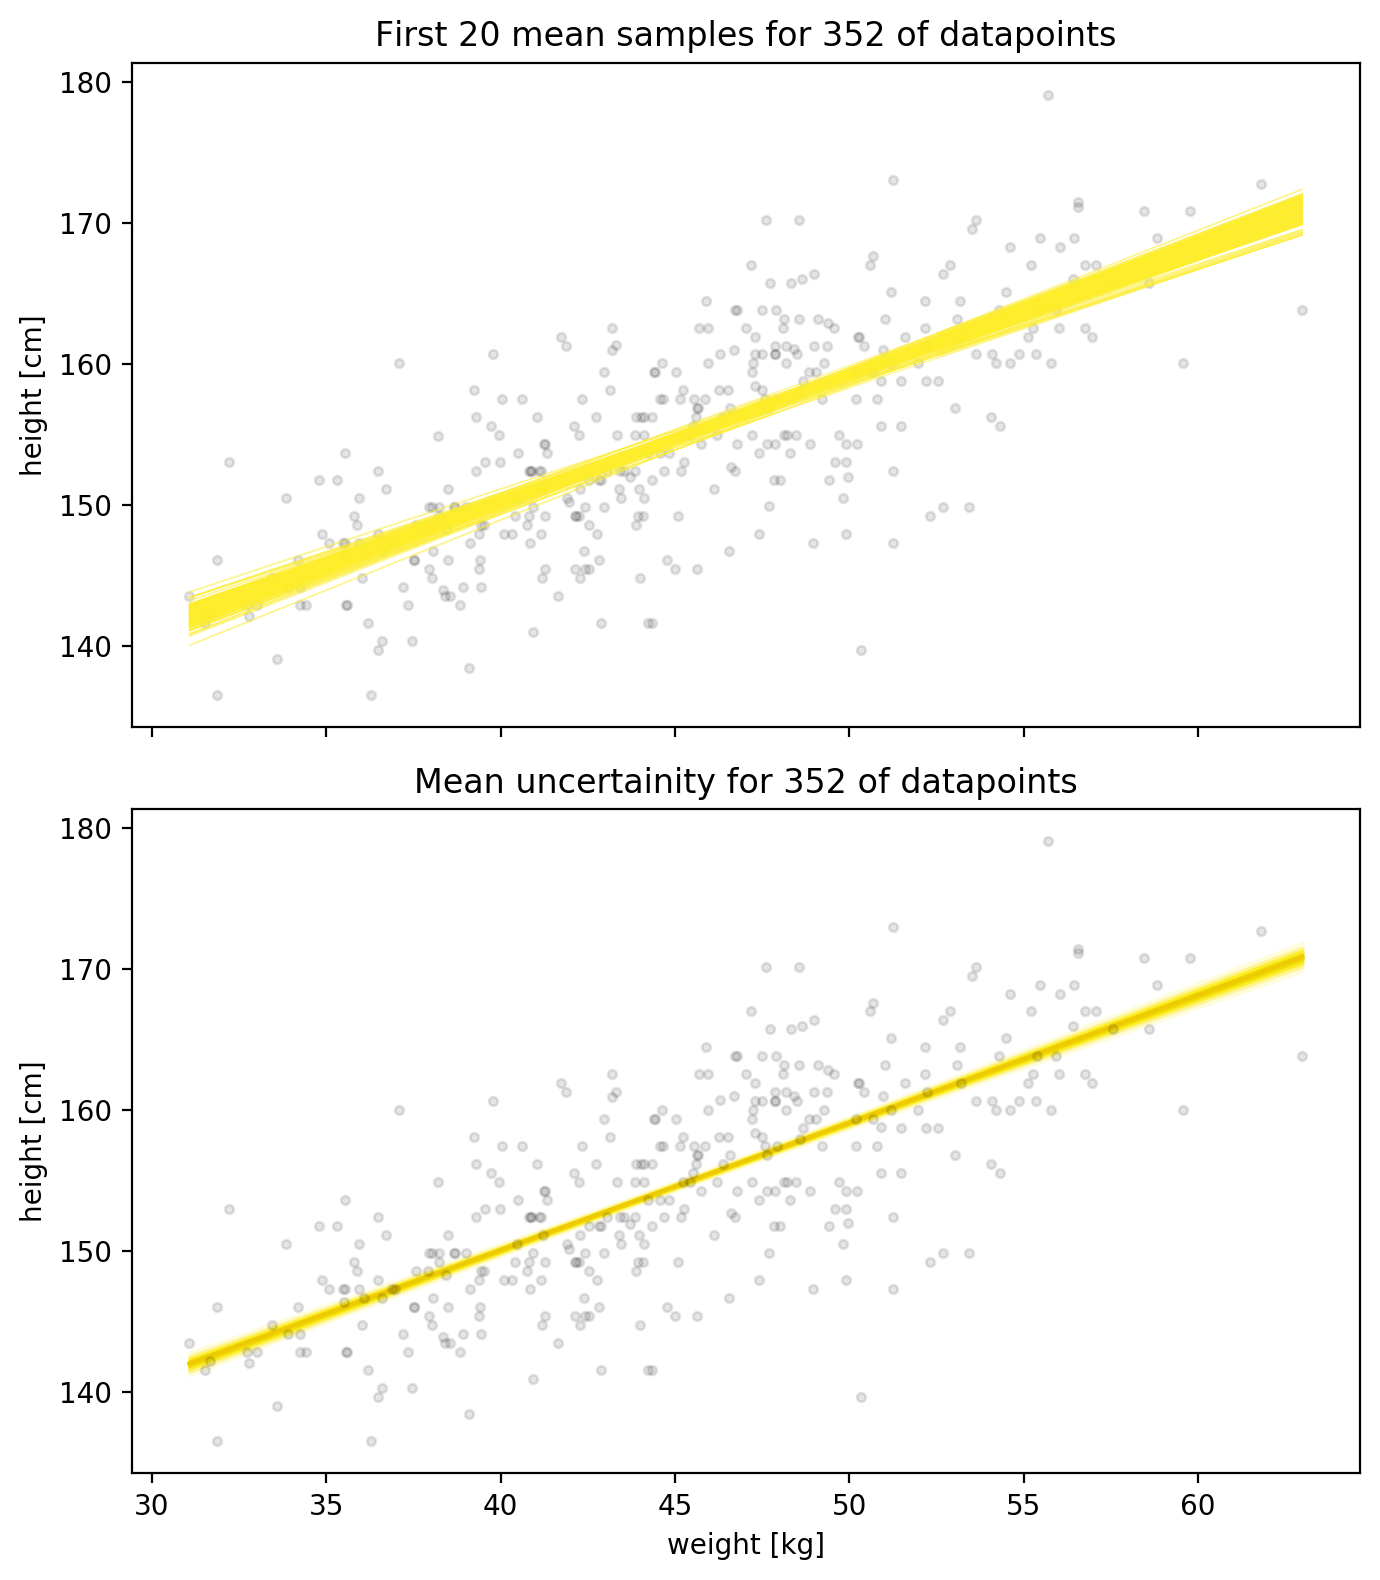

In [104]:
fig, axes = plt.subplots(2,1, figsize=(7, 8),sharey=True,sharex=True)
ax0=axes[0]
for i in range(100):
    ax0.plot(d_short.weight,
              alpha_fit[i]+beta_fit[i]*d_short.c_weight,
              color=mid,
              alpha=0.5,linewidth=0.5)
ax0.scatter(d_short.weight,d_short.height,color='black',alpha=0.1,s=10)
ax0.set_ylabel('height [cm]')
ax0.set_title('First 20 mean samples for {} of datapoints'.format(len(d_short)))
ax1=axes[1]
ax1=ribbon_plot(d_short.weight.values,mu_fit,ax1)
ax1.scatter(d_short.weight,d_short.height,color='black',alpha=0.1,s=10)
ax1.set_xlabel('weight [kg]')
ax1.set_ylabel('height [cm]')

ax1.set_title('Mean uncertainity for {} of datapoints'.format(len(d_short)))
fig.tight_layout()
plt.show()

Sorting


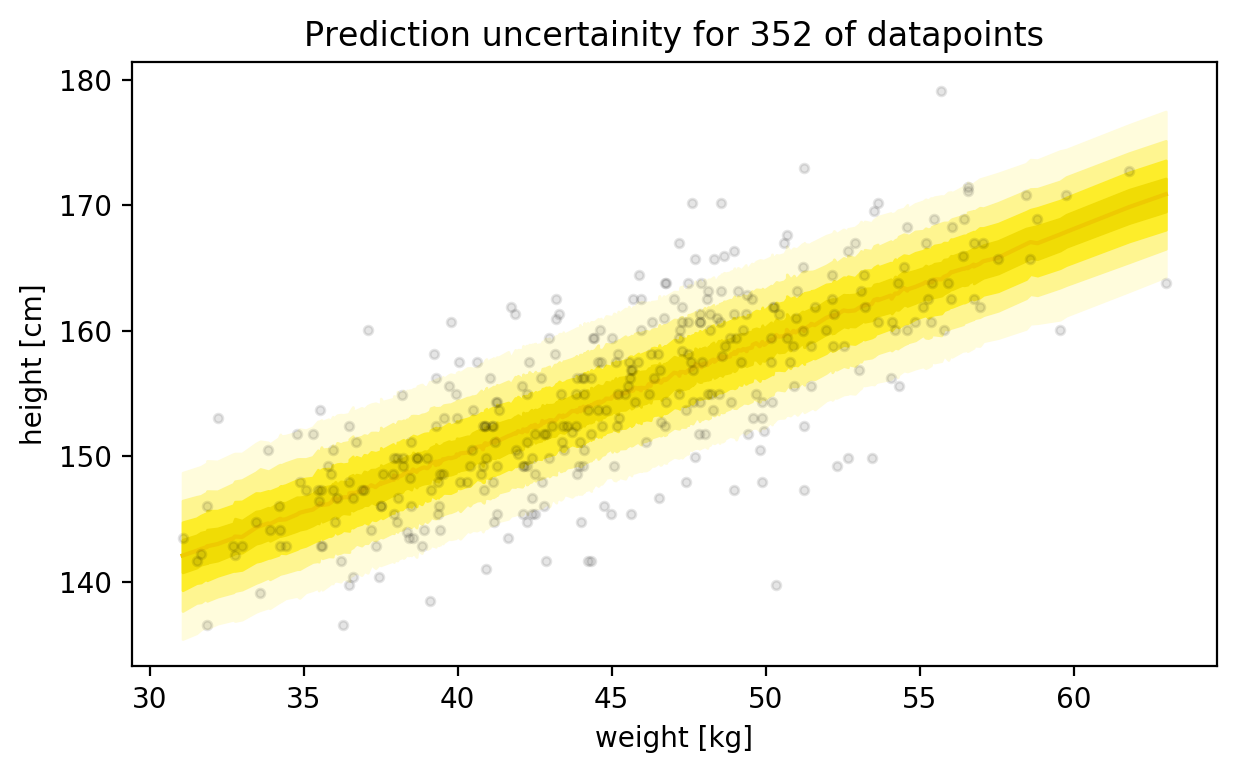

In [105]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(d_short.weight.values,height_pred,axes)
axes.scatter(d_short.weight,d_short.height,color='black',alpha=0.1,s=10)
axes.set_xlabel('weight [kg]')
axes.set_ylabel('height [cm]')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(d_short)))
plt.show()


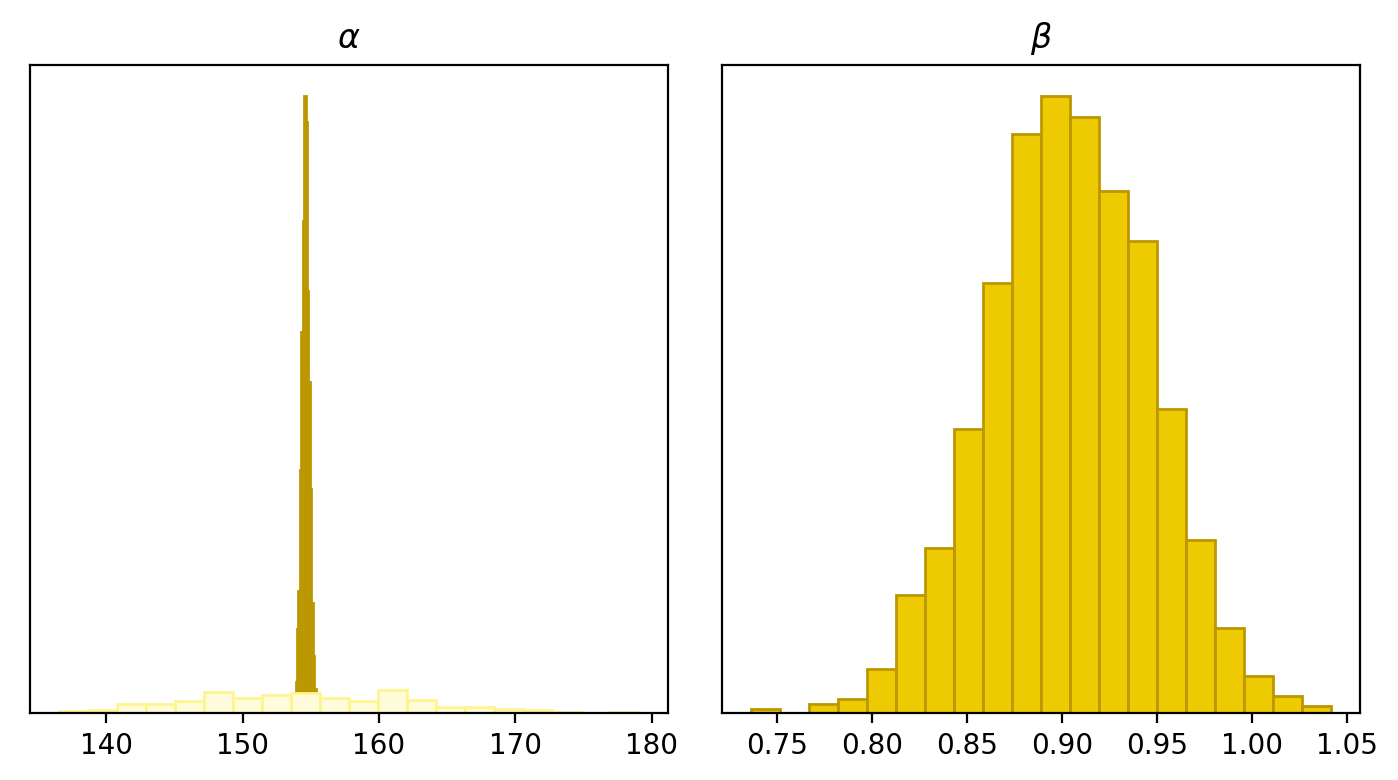

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
ax = axes[0]
ax.hist(alpha_fit,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax.hist(d.height,bins=20,color=light,edgecolor=light_highlight,density=True)
ax.set_title(r'$\alpha$')
ax.set_yticks(())
ax2 = axes[1]
ax2.hist(beta_fit,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'$\beta$')
ax2.set_yticks(())
fig.tight_layout()
plt.show()

### Marginal for selected weight
What if we want to focus on predictions for selected weight?

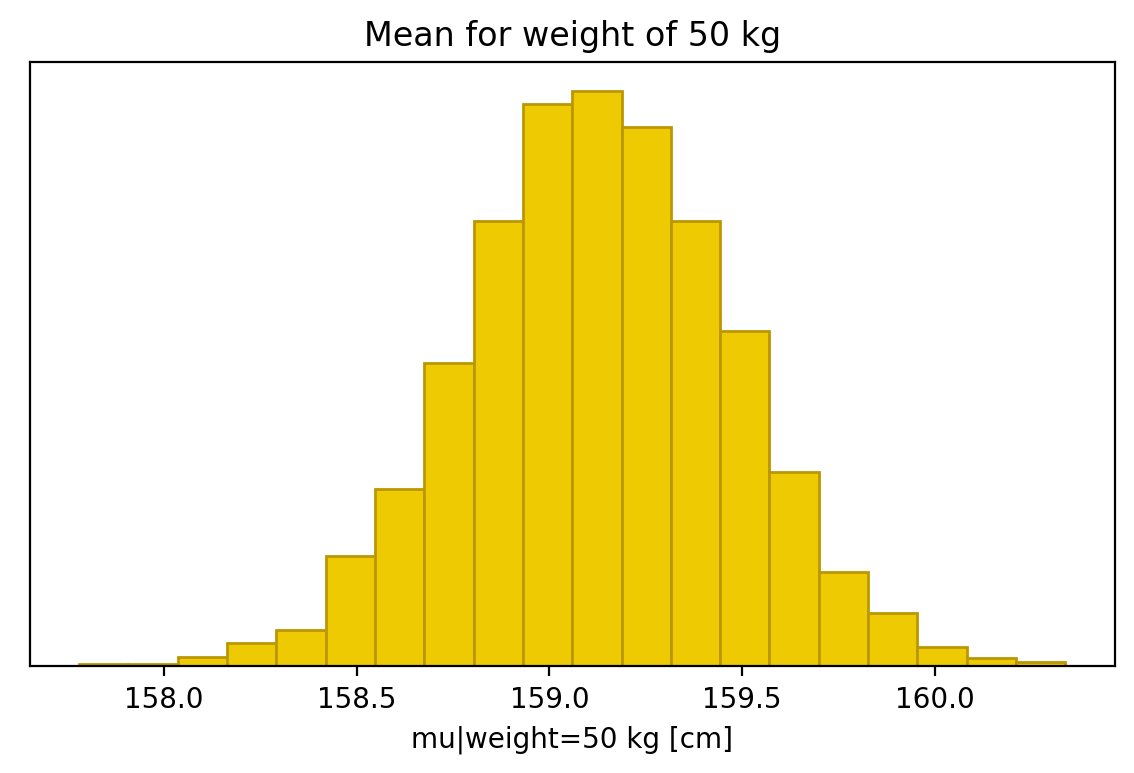

In [107]:
mu50 = alpha_fit+beta_fit*(50-d.weight.mean())

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(mu50,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax.set_title('Mean for weight of 50 kg')
ax.set_yticks(())
ax.set_xlabel('mu|weight=50 kg [cm]')
plt.show()

### Extending of the dataset
We will now consider full dataset including children.

In [108]:
d= pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)

### Standarization of variables

In [109]:
d['c_weight']=d.weight-d.weight.mean()
d['s_weight']=d['c_weight']/d['weight'].std()
d.head()

,height,weight,age,male,c_weight,s_weight
0,151.765,47.825606,63.0,1,12.214989,0.829869
1,139.700,36.485807,63.0,0,0.875189,0.059459
2,136.525,31.864838,65.0,0,-3.745780,-0.254483
3,156.845,53.041915,41.0,1,17.431297,1.184257
4,145.415,41.276872,51.0,0,5.666254,0.384957


### How our model works for that one?

In [110]:
data_fit=dict(N=len(d),
              weight=d.s_weight.values,
              heights=d.height.values)

fit=model_2_fit.sampling(data=data_fit,seed=28052020)
params_fit=fit.extract()
alpha_fit=params_fit['alpha']
beta_fit=params_fit['beta']
mu_fit=params_fit['mu']
height_pred=params_fit['height']

az.summary(fit,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


,mean,sd,hpd_3%,hpd_97%
alpha,138.28,0.40,137.58,139.07
beta,25.93,0.41,25.15,26.69
sigma,9.38,0.28,8.89,9.94


Sorting


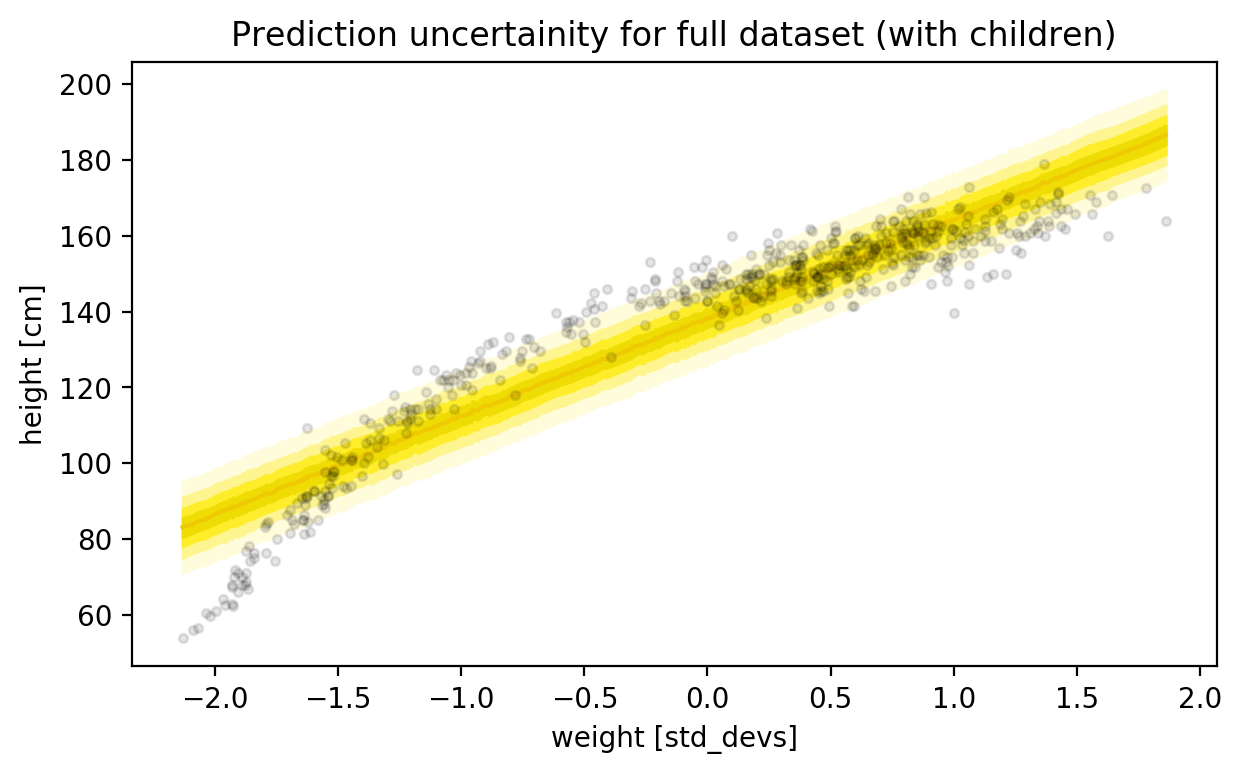

In [111]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes=ribbon_plot(d.s_weight.values,height_pred,axes)
axes.scatter(d.s_weight,d.height,color='black',alpha=0.1,s=10)
axes.set_xlabel('weight [std_devs]')
axes.set_ylabel('height [cm]')
axes.set_title('Prediction uncertainity for full dataset (with children)')
plt.show()


### Adding higher orders
Our data for the entire dataset expresses much more curvature than the linear model can capture.
Lets extend our model by adding quadratic term i.e.
$$
\mu_i = \alpha+\beta_1\cdot\mathrm{weight}_i+\beta_2\cdot\mathrm{weight}_i^2
$$

### Prior predictive checks

In [112]:
with open('height_3_ppc.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real weight[N];
}

generated quantities {
  real alpha = normal_rng(178,20);
  real beta_1 = lognormal_rng(0,1);
  real beta_2 = normal_rng(0,10);
  real sigma = exponential_rng(0.067);
  real height[N];
  for (i in 1:N) {
    height[i] = normal_rng(weight[i]*beta_1+weight[i]^2*beta_2+alpha,sigma);
  }

}



In [113]:
model_3_ppc=stan_utility.compile_model('height_3_ppc.stan')

R = 1000
data_sim=dict(N=50,weight=np.linspace(d.s_weight.min(),d.s_weight.max()))
sim=model_3_ppc.sampling(data=data_sim, iter=R, warmup=0, chains=1, refresh=R,algorithm='Fixed_param',
                     seed=29042020)

params_sim=sim.extract()
alpha_sim=params_sim['alpha']
beta_1_sim=params_sim['beta_1']
beta_2_sim=params_sim['beta_2']
height_sim=params_sim['height']

Using cached StanModel


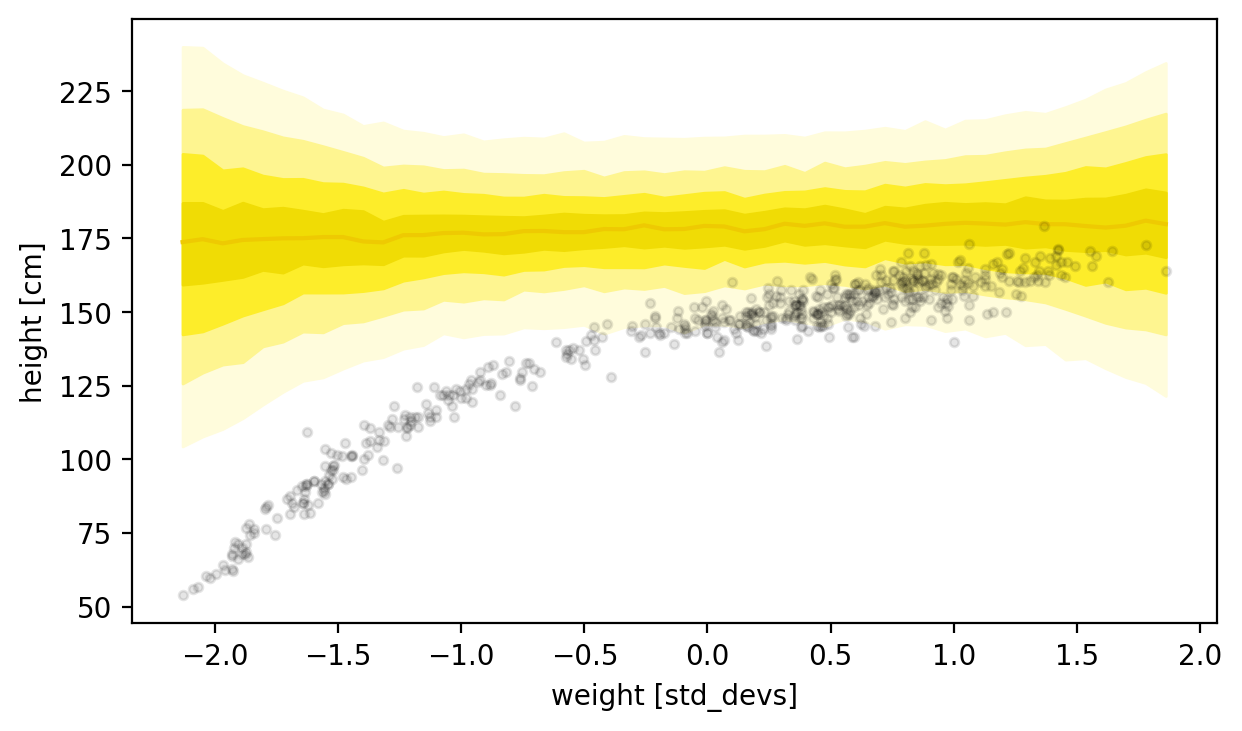

In [114]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes=ribbon_plot(data_sim['weight'],height_sim,axes)
axes.scatter(d.s_weight,d.height,color='black',alpha=0.1,s=10)
axes.set_xlabel('weight [std_devs]')
axes.set_ylabel('height [cm]')
plt.show()

In [115]:
az.summary(sim,var_names=['alpha','beta_1','beta_2','sigma'],round_to=2,kind='stats')

,mean,sd,hpd_3%,hpd_97%
alpha,178.01,19.39,140.34,212.49
beta_1,1.56,1.72,0.05,4.72
beta_2,-0.41,10.25,-18.64,17.87
sigma,14.05,13.35,0.00,40.82


In [116]:
with open('height_3_fit.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] weight;
  real heights[N];
}

parameters {
  real alpha;
  real beta_1;
  real beta_2;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu;
  for (i in 1:N) {
    mu[i] = weight[i]*beta_1+weight[i]^2*beta_2+alpha;
  }
}

model {
  alpha ~ normal(178,20);
  beta_1 ~ lognormal(0,1);
  beta_2 ~ normal(0,10);
  sigma ~ exponential(0.067);
  heights ~ normal(mu,sigma);
}

generated quantities {
  real height[N];
  for (i in 1:N) {
    height[i] = normal_rng(mu[i],sigma);
  }
}



In [117]:
model_3_fit=stan_utility.compile_model('height_3_fit.stan')

Using cached StanModel


In [118]:
data_fit=dict(N=len(d),
              weight=d.s_weight.values,
              heights=d.height.values)

fit=model_3_fit.sampling(data=data_fit,seed=28052020)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [119]:
params_fit=fit.extract()

height_pred=params_fit['height']
beta_2 = params_fit['height']


Sorting


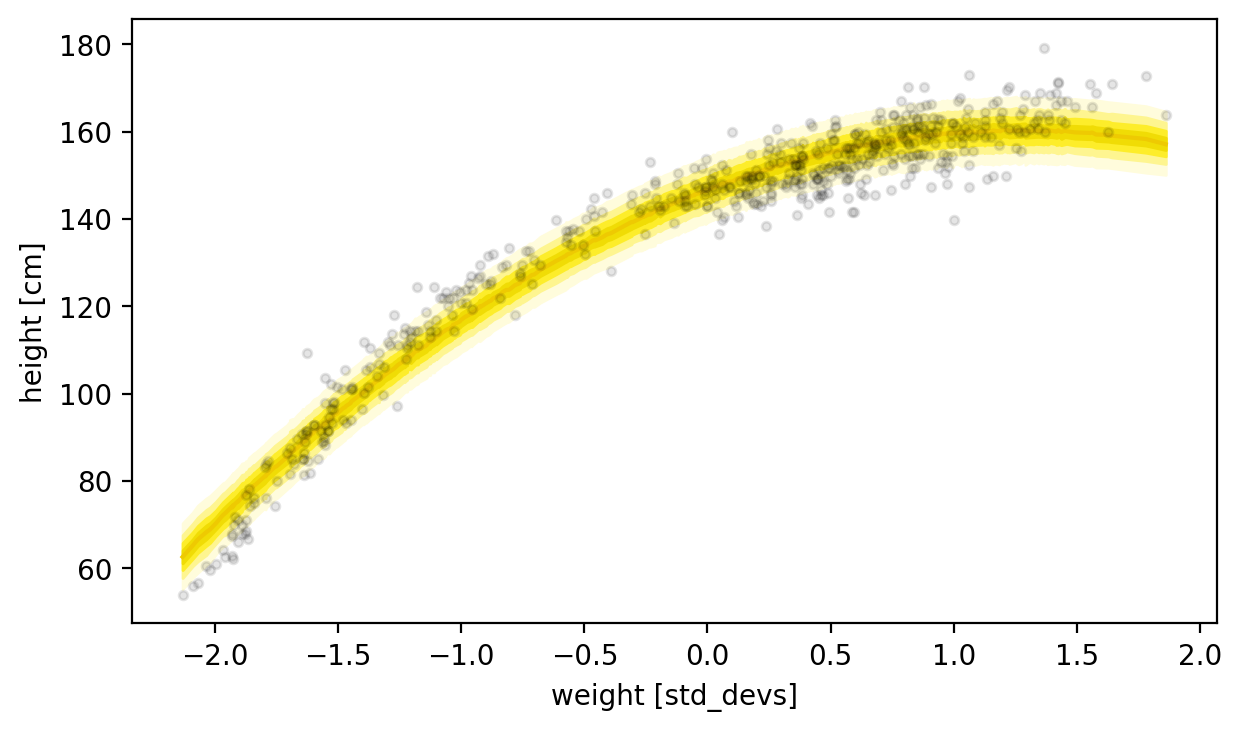

In [120]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes=ribbon_plot(d.s_weight.values,height_pred,axes)
axes.scatter(d.s_weight,d.height,color='black',alpha=0.1,s=10)
axes.set_xlabel('weight [std_devs]')
axes.set_ylabel('height [cm]')
plt.show()


In [121]:
az.summary(fit,var_names=['alpha','beta_1','beta_2','sigma'],round_to=2,kind='stats')

,mean,sd,hpd_3%,hpd_97%
alpha,146.66,0.36,145.96,147.32
beta_1,21.40,0.28,20.85,21.92
beta_2,-8.41,0.28,-8.95,-7.93
sigma,5.78,0.17,5.47,6.10


### Is this the more efficient way of adding predictors?
Obviously not, functions of predictors can be computed earlier.

### Creating a design matrix

In [122]:
d.head()

,height,weight,age,male,c_weight,s_weight
0,151.765,47.825606,63.0,1,12.214989,0.829869
1,139.700,36.485807,63.0,0,0.875189,0.059459
2,136.525,31.864838,65.0,0,-3.745780,-0.254483
3,156.845,53.041915,41.0,1,17.431297,1.184257
4,145.415,41.276872,51.0,0,5.666254,0.384957


In [123]:
d['s_weight^2']=d['s_weight']**2
d['s_weight^3']=d['s_weight']**3

In [54]:
d.head()

,height,weight,age,male,c_weight,s_weight,s_weight^2,s_weight^3
0,151.765,47.825606,63.0,1,12.214989,0.829869,0.688682,0.571516
1,139.700,36.485807,63.0,0,0.875189,0.059459,0.003535,0.000210
2,136.525,31.864838,65.0,0,-3.745780,-0.254483,0.064762,-0.016481
3,156.845,53.041915,41.0,1,17.431297,1.184257,1.402466,1.660881
4,145.415,41.276872,51.0,0,5.666254,0.384957,0.148192,0.057048


In [124]:
X=d.iloc[:,-3:].values

In [125]:
with open('height_4_fit.stan', 'r') as file:
    print(file.read())

data {
  int N; //number of measurements
  int K; //number of predictors
  matrix [N,K] X; //design matrix
  real heights[N];
}

parameters {
  real alpha;
  vector[K] beta;

  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu = X*beta+alpha;
}

model {
  alpha ~ normal(178,20);
  beta ~ normal(0,10);
  sigma ~ exponential(0.067);
  heights ~ normal(mu,sigma);
}

generated quantities {
  real height[N];
  for (i in 1:N) {
    height[i] = normal_rng(mu[i],sigma);
  }
}



In [126]:
model_4_fit=stan_utility.compile_model('height_4_fit.stan')

Using cached StanModel


In [127]:
data_fit=dict(N=len(d),
              K=3, 
              X=X,
              heights=d.height.values)
fit=model_4_fit.sampling(data=data_fit,seed=28052020)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [128]:
params_fit=fit.extract()
height_pred=params_fit['height']


Sorting


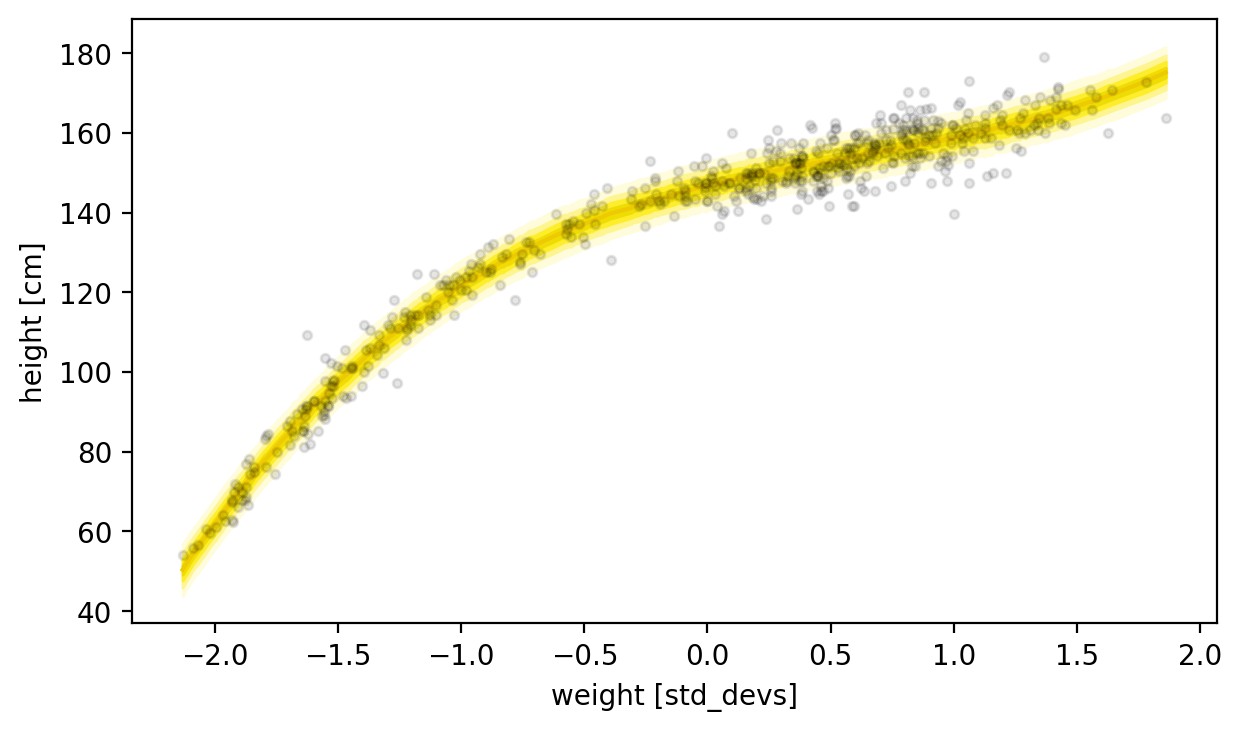

In [131]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes=ribbon_plot(d.s_weight.values,height_pred,axes)
axes.scatter(d.s_weight,d.height,color='black',alpha=0.1,s=10)
axes.set_xlabel('weight [std_devs]')
axes.set_ylabel('height [cm]')
plt.show()


In [130]:
az.summary(fit,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

,mean,sd,hpd_3%,hpd_97%
alpha,146.74,0.32,146.17,147.38
beta[0],15.03,0.48,14.07,15.89
beta[1],-6.55,0.27,-7.07,-6.04
beta[2],3.59,0.23,3.17,4.05
sigma,4.85,0.15,4.56,5.12
